In [12]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

<Axes: xlabel='Date'>

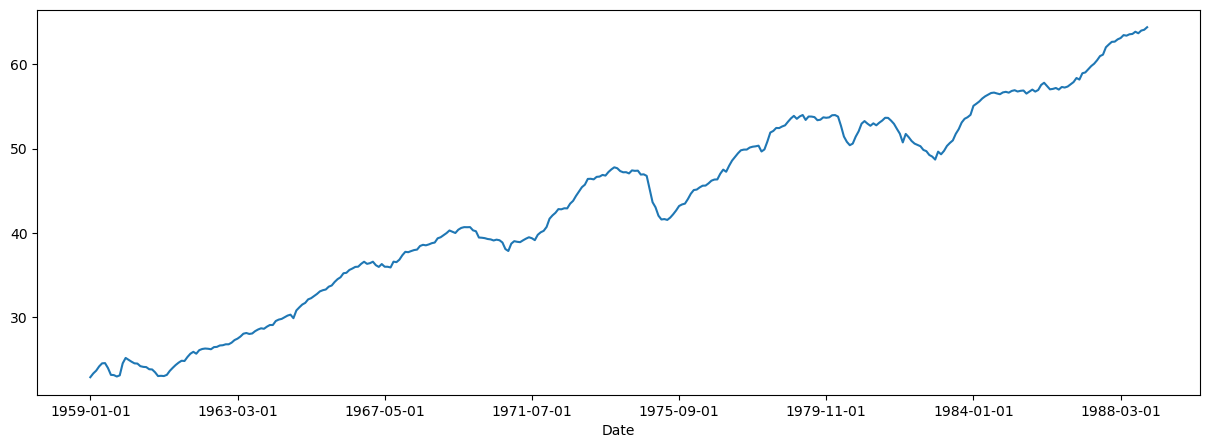

In [84]:
rcParams['figure.figsize'] = 15, 5
# считывание файла
dataset = pd.read_csv("Downloads/training.csv", index_col='Date')
value = dataset['Value']
# Построение графика временного ряда
value.plot()

In [85]:
#  Исследование ряда на стационарность
def stationary_series(time_series):
    # Построение скользящего среднего
    r_mean = time_series.rolling(window=15, center=False)
    r_std = time_series.rolling(window=15, center=False)
    time_series.plot(color='orange', label='Original')
    r_mean.mean().plot(color='brown', label='Rolling Mean')
    r_std.std().plot(color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Коэффициент вариации
    V = time_series.std() / time_series.mean()
    print('Коэффициент вариации V = ', V)
    # Тест Дики-Фуллера
    test_adf = sm.tsa.adfuller(time_series, autolag='AIC')
    print('adf: ', test_adf[0])
    print('p-value: ', test_adf[1])
    print('Critical values: ', test_adf[4])
    if test_adf[0] > test_adf[4]['5%']: 
        print('Есть единичные корни - ряд не стационарен')
        return -1
    else:
        print('Единичных корней нет - ряд стационарен')
        return 1

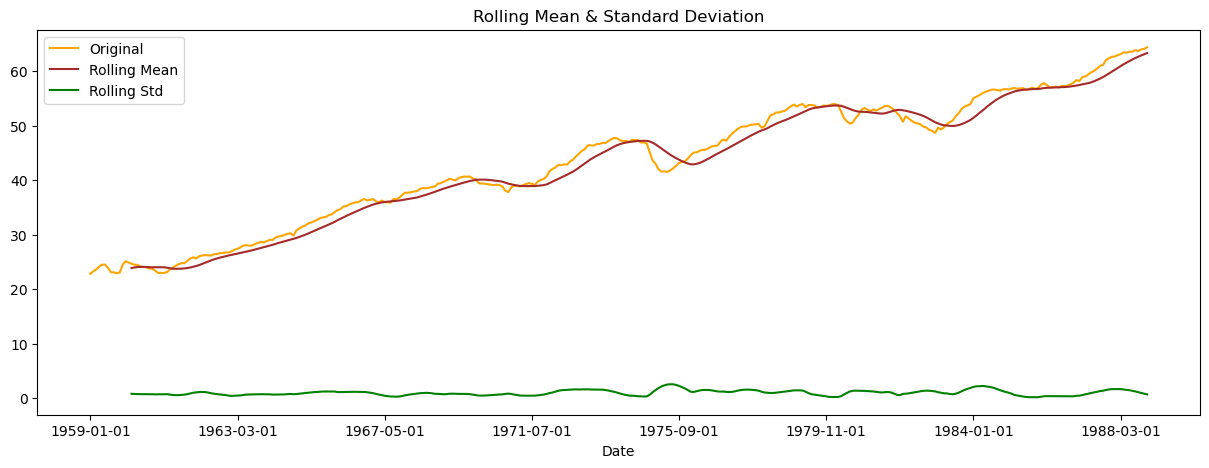

Коэффициент вариации V =  0.264052125707261
adf:  -0.2533911799284586
p-value:  0.9318510422993471
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Есть единичные корни - ряд не стационарен


-1

In [86]:
stationary_series(value)

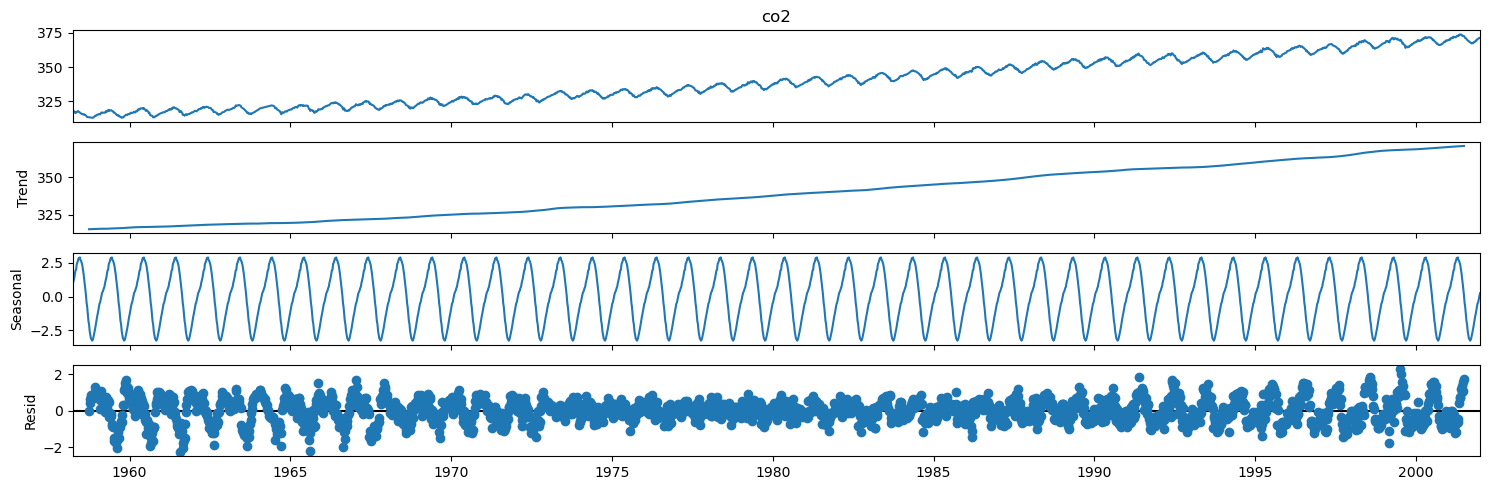

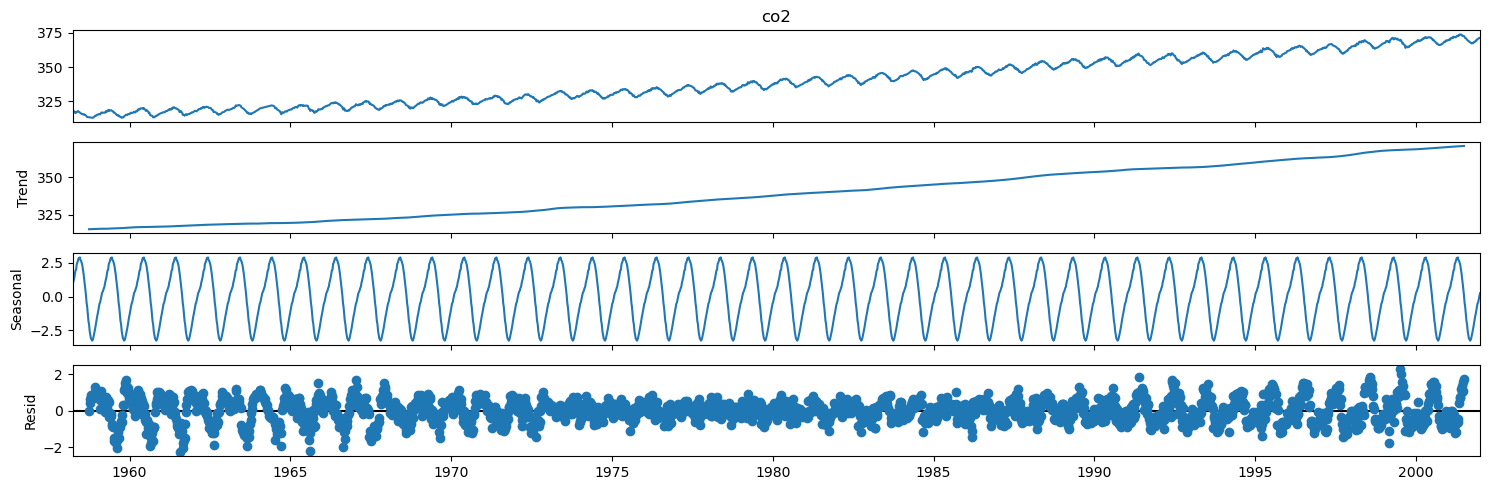

In [87]:
# Разложение временного ряда на тренд, сезональность и остаток
time_series = sm.datasets.co2.load_pandas().data
time_series.co2.interpolate(inplace=True)
decompos = sm.tsa.seasonal_decompose(time_series.co2)
decompos.plot()

Проверка тренда на стационарность:


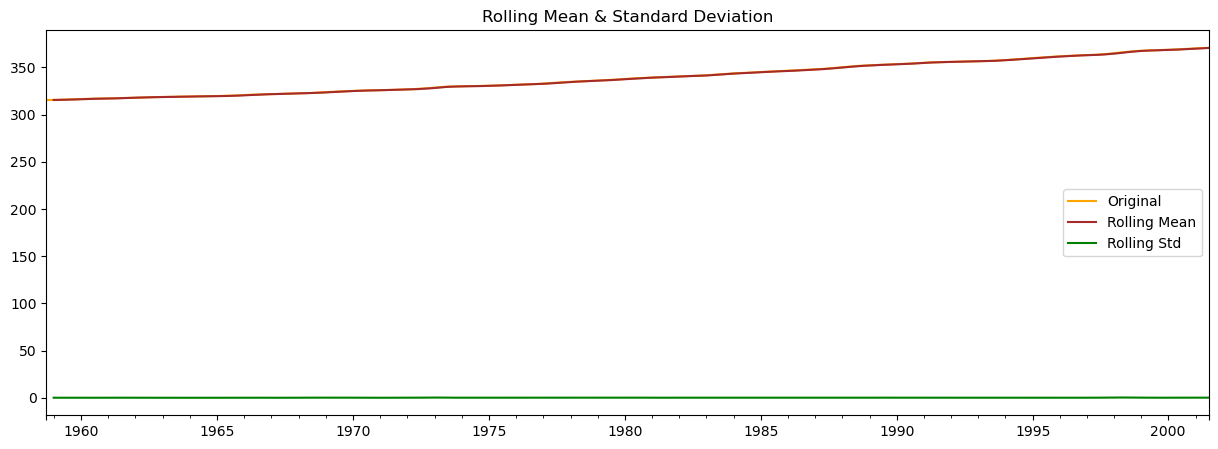

Коэффициент вариации V =  0.04901934218202132
adf:  2.111676764589343
p-value:  0.9988015972939192
Critical values:  {'1%': -3.4333191288144413, '5%': -2.8628516682161713, '10%': -2.567468264817643}
Есть единичные корни - ряд не стационарен
Проверка сезональности на стационарность:


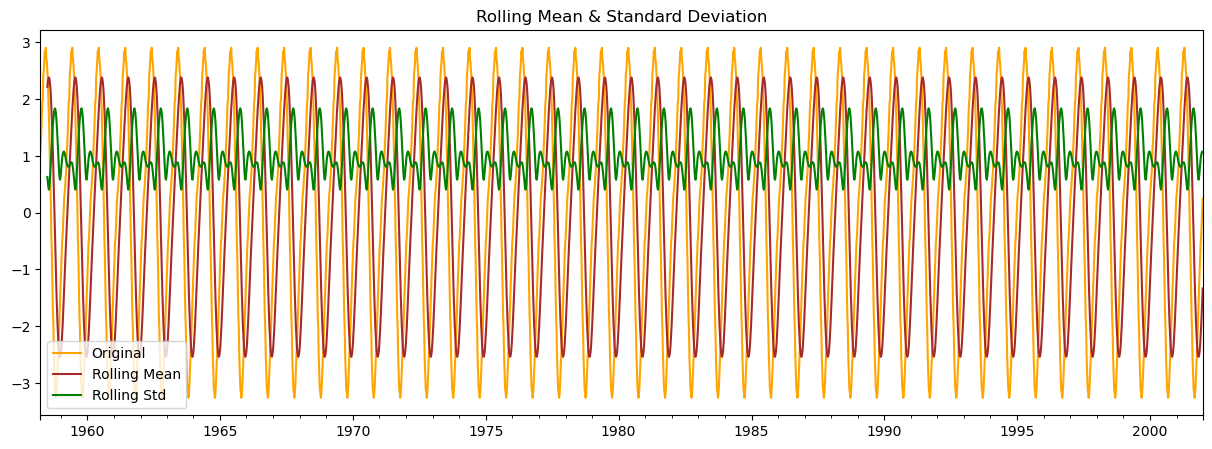

Коэффициент вариации V =  -2075.0994826531037
adf:  -28.41973189682279
p-value:  0.0
Critical values:  {'1%': -3.4332519309441296, '5%': -2.8628219967376647, '10%': -2.567452466810334}
Единичных корней нет - ряд стационарен
Проверка остатка на стационарность:


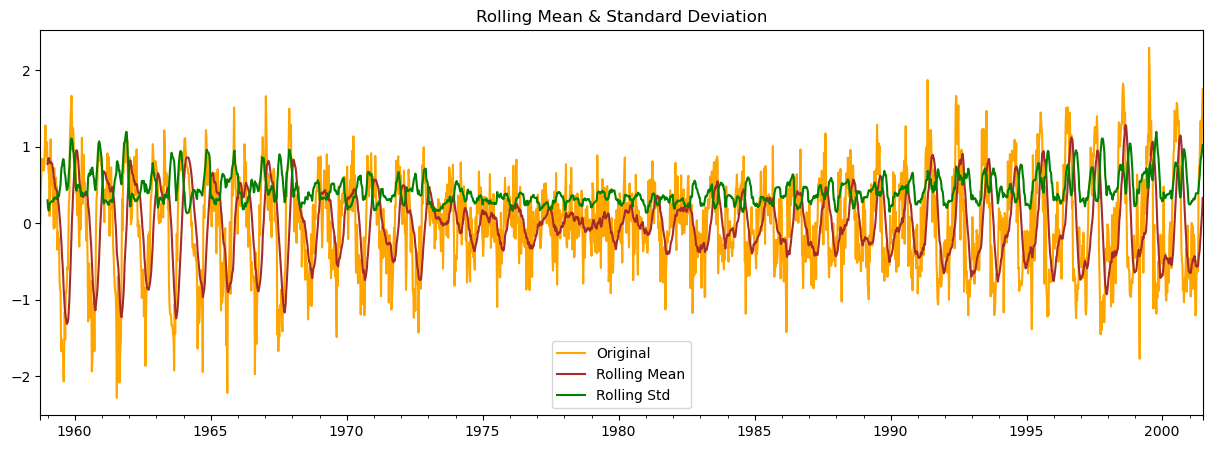

Коэффициент вариации V =  152.76286051354379
adf:  -15.757448929301226
p-value:  1.202872007295381e-28
Critical values:  {'1%': -3.4333204775429715, '5%': -2.8628522637456255, '10%': -2.5674685818969634}
Единичных корней нет - ряд стационарен


1

In [88]:
print('Проверка тренда на стационарность:')
time_series_log_decompos = decompos.trend
time_series_log_decompos.dropna(inplace=True)
stationary_series(time_series_log_decompos)
print('Проверка сезональности на стационарность:')
time_series_log_decompos = decompos.seasonal
time_series_log_decompos.dropna(inplace=True)
stationary_series(time_series_log_decompos)
print('Проверка остатка на стационарность:')
time_series_log_decompos = decompos.resid
time_series_log_decompos.dropna(inplace=True)
stationary_series(time_series_log_decompos)

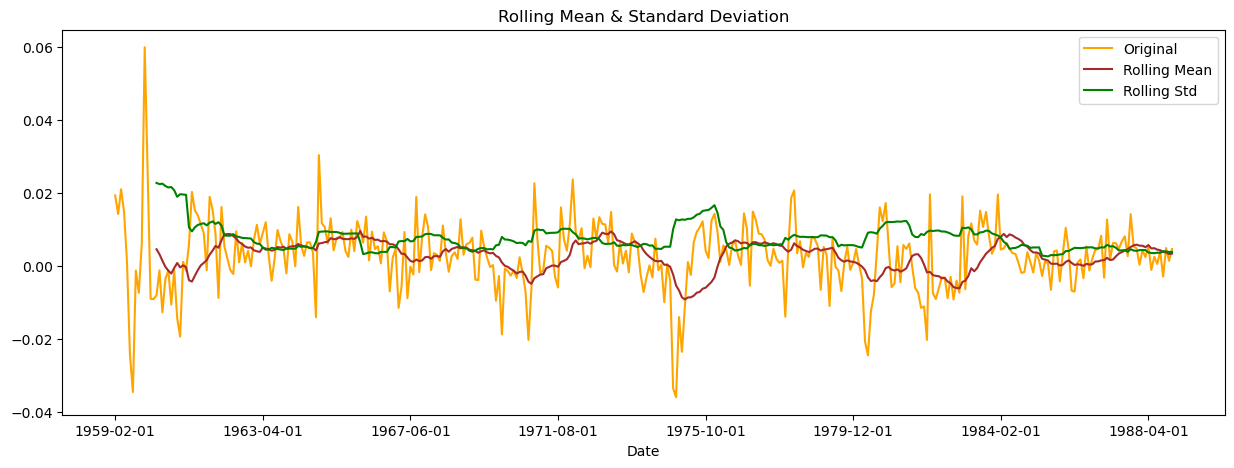

Коэффициент вариации V =  3.254522541056757
adf:  -8.187894507566554
p-value:  7.809572497701443e-13
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Единичных корней нет - ряд стационарен
Ряд является интегрированным первого порядка


In [89]:
# Проверим, является ли временный ряд интегрированным порядка k
# Если первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.
value_log = np.log(value)
value_log_diff = value_log - value_log.shift()
value_log_diff.dropna(inplace=True)
# d параметр в модели ARIMA
d = stationary_series(value_log_diff)
if d:
    print("Ряд является интегрированным первого порядка")

Проверить ряд на порядок интегрированности не выше k = 4


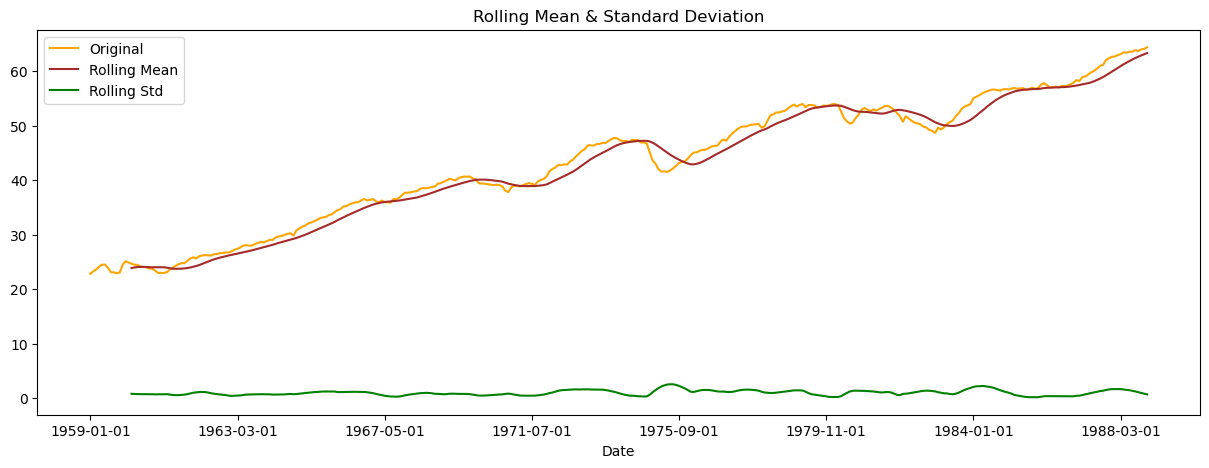

Коэффициент вариации V =  0.264052125707261
adf:  -0.2533911799284586
p-value:  0.9318510422993471
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Есть единичные корни - ряд не стационарен
Ряд интегрированности порядка k =  1


In [90]:
# Данная функция проверяет ряд на порядок интегрированности не выше заданного k
def integration_k(time_series, k):
    test_stationary = stationary_series(time_series)
    n = 1
    while not test_stationary and n <= k:
        time_series = time_series.diff(periods=1).dropna()
        test_stationary = test_stationary(time_series)
        if test_stationary:
            break
        n += 1
    if test_stationary:
        print('Ряд интегрированности порядка k = ', n)
        return n
    else:
        print('Ряд не является интегрированным')
        return -1
n = input('Проверить ряд на порядок интегрированности не выше k = ')
for order in n:
    integration_k(value, order)



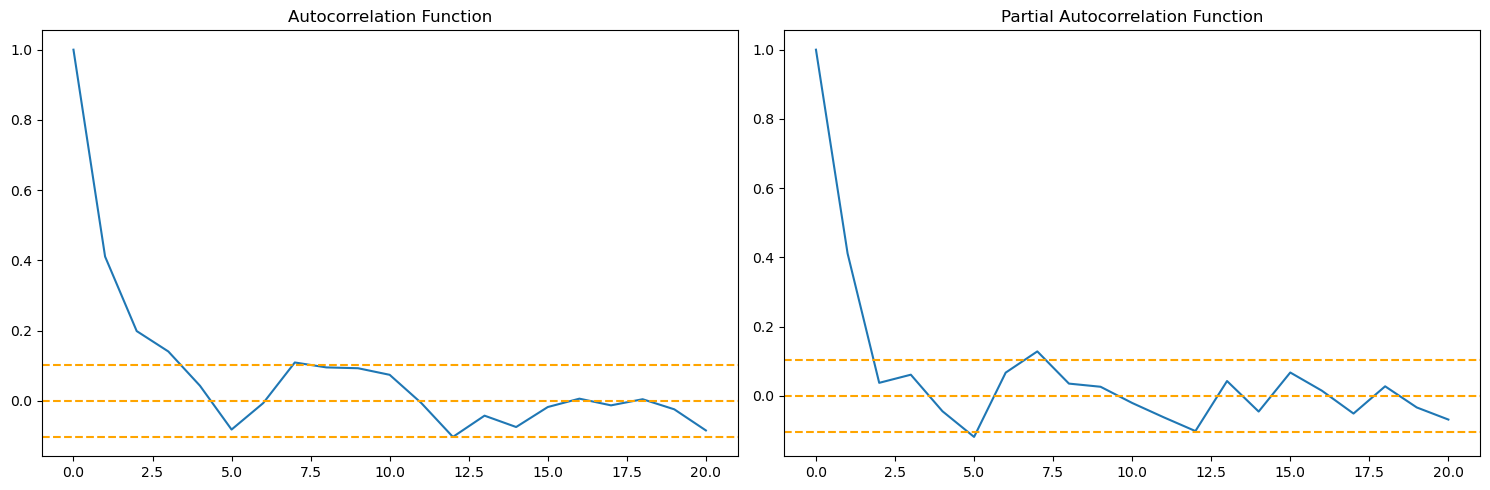

In [91]:
# Необходимо узнать параметры q и p в модели ARIMA, параметр d равен порядку интегрируемости ряда
# Для этого надо изучить автокорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(value_log_diff, nlags=20)
lag_pacf = pacf(value_log_diff, nlags=20, method='ols')

# Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='orange')
plt.axhline(y=(-1.96 / np.sqrt(len(value_log_diff))), linestyle='--', color='orange')
plt.axhline(y=(1.96 / np.sqrt(len(value_log_diff))), linestyle='--', color='orange')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='orange')
plt.axhline(y=(-1.96 / np.sqrt(len(value_log_diff))), linestyle='--', color='orange')
plt.axhline(y=(1.96 / np.sqrt(len(value_log_diff))), linestyle='--', color='orange')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

q = int(lag_acf[0])
p = int(lag_pacf[0])

In [92]:
from statsmodels.tsa.arima_model import ARIMA


def arima(val, val_diff, p, d, q):
    val.index = pd.to_datetime(val.index)
    model = ARIMA(val, order=(p, d, q))
    res_model = model.fit(disp = -1) 
    res_model.fittedvalues.plot(color='orange')
    val_diff.plot(color='brown')
    plt.title('RSS: %.4f' % sum((res_model.fittedvalues - val_diff)**2))
    return res_model


In [93]:
# AR
res_AR = arima(value_log, value_log_diff, p, d, 0)

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [94]:
# MA
res_MA = arima(value_log, value_log_diff, 0, d, q)

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [75]:
# ARIMA 
res_ARIMA = arima(value_log, value_log_diff, p, d, q)

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [76]:
# с помощью информационного критерия Акаике находим наилучшую модель
aic = np.array([res_ARIMA.aic, res_AR.aic, res_MA.aic])
if aic.argmin() == 0:
    print('ARIMA is the BEST')
if aic.argmin() == 1:
    print('AR is the BEST')
if aic.argmin() == 2:
    print('MA is the BEST')

NameError: name 'res_ARIMA' is not defined

In [77]:
# Конвертация ряда к исходной размерности  
def convert(predictions_mod_diff: object, tser_log: object) -> object:
    predictions_mod_diff_cumsum = predictions_mod_diff.cumsum()
    predictions_mod_log = pd.Series(value_log.ix[0], index=value_log.index)
    predictions_mod_log = predictions_mod_log.add(predictions_mod_diff_cumsum, fill_value=0)
    predictions_mod = np.exp(predictions_mod_log)
    return predictions_mod

In [78]:
# Результаты модели ARIMA для исходных данных: 
predictions_ARIMA_diff = pd.Series(res_ARIMA.fittedvalues, copy=True)
predictions_ARIMA = convert(predictions_ARIMA_diff, value_log)
value.index = pd.to_datetime(value.index)
value.plot(color='brown')
predictions_ARIMA.plot(color='orange')
r2 = r2_score(value, predictions_ARIMA)
plt.title('R^2: %1.2f' % r2)

NameError: name 'res_ARIMA' is not defined

In [79]:
from sklearn.metrics import r2_score 
# Считывание тестовой выборки
dataset_test = pd.read_csv("Downloads/testing.csv", index_col='Date')
value = dataset_test['Value']
value_log = np.log(value)

In [80]:
predict_log = res_ARIMA.predict(start='1988-12-01', end='1993-12-01')
prediction = pd.Series(res_ARIMA.predict('1989-01-01', '1993-12-01', typ='linear'), copy=True)
res = convert(prediction, value_log)
value.plot(color='brown')
res.plot(color='orange')
r2 = r2_score(value, res)
plt.title('R^2: %1.2f' % r2)

NameError: name 'res_ARIMA' is not defined

In [81]:
predict_log = res_AR.predict(start='1988-12-01', end='1993-12-01')
prediction = pd.Series(res_AR.predict('1989-01-01', '1993-12-01', typ='linear'), copy=True)
res = convert(prediction, value_log)
value.plot(color='brown')
res.plot(color='orange')
r2 = r2_score(value, res)
plt.title('R^2: %1.2f' % r2)

NameError: name 'res_AR' is not defined

In [82]:
predict_log = res_MA.predict(start='1988-12-01', end='1993-12-01')
prediction = pd.Series(res_MA.predict('1989-01-01', '1993-12-01', typ='linear'), copy=True)
res = convert(prediction, value_log)
value.plot()
res.plot(color='orange')
r2 = r2_score(value, res)
plt.title('R^2: %1.2f' % r2)

NameError: name 'res_MA' is not defined